In [9]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import UtilNNDL as util

from keras.models import Sequential
from keras.layers import Dense, Permute
from keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D
from keras.layers import MaxPooling1D, Conv1D
from keras.layers import GRU, LSTM, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Flatten, Reshape
from keras.utils import to_categorical
from keras.layers import Activation
from UtilNNDL import plot_hist

folder = '/home/carla/Downloads/project_datasets/project_datasets/'
#folder = 'datasets/'
A01T = h5py.File(folder+'A01T_slice.mat','r')
data = np.copy(A01T['image'])
labels = np.copy(A01T['type'])
labels = labels[0,0:data.shape[0]:1]
labels = np.asarray(labels, dtype=np.int32)

a = data[:56]
b = data[57:]
data = np.vstack((a,b))
data = data[:,:22,:]
a = labels[:56]
b = labels[57:]
labels = np.hstack((a,b))
print data.shape

(287, 22, 1000)


In [3]:
data2d_sliced, labels_sliced = util.create_window_data(data, labels)
#util.plot_hist(data2d_sliced)
print data2d_sliced.shape, labels_sliced.shape
data2d = data2d_sliced.reshape(data2d_sliced.shape[0], data2d_sliced.shape[2], data2d_sliced.shape[1], 1)
print data2d.shape

#enc = OneHotEncoder()
#enc_labels = enc.fit_transform(labels.reshape(-1,1)).toarray()
enc_labels = to_categorical(labels_sliced-769, num_classes=4)
print(enc_labels.shape)

(2870, 22, 512) (2870,)
(2870, 512, 22, 1)
(2870, 4)


In [5]:
bs, t, n, c = data2d.shape
np.random.seed(42)
shuffle = np.random.choice(bs,bs,replace=False)

#mask = np.ones_like(data)
#mask[[:,:,21:24]] = True
#newdata = data[mask]
#np.delete(mask, :,:,24)
train_samples = bs - 50
train_data = data2d[shuffle[:train_samples],:,:]
train_labels = enc_labels[shuffle[:train_samples]]
test_data = data2d[shuffle[train_samples:],:,:]
test_labels = enc_labels[shuffle[train_samples:]]
print data2d.shape
print train_data.shape
print test_data.shape

(2870, 512, 22, 1)
(2820, 512, 22, 1)
(50, 512, 22, 1)


# TESTING


In [8]:
num_filters = 10
model = Sequential()
model.add(Conv2D(num_filters, kernel_size=(num_filters,1), activation='relu', data_format='channels_last', input_shape=(data2d.shape[1], data2d.shape[2], data2d.shape[3])))  
model.add(Conv2D(num_filters, kernel_size=(15,num_filters), activation='relu') ) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*2, kernel_size=(10,num_filters), activation='relu') ) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*4, kernel_size=(10,num_filters*2), activation='relu') ) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*8, kernel_size=(10,num_filters*4), activation='relu') ) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Reshape((num_filters*8,1)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
#model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
hist = model.fit(train_data,train_labels,epochs=10,validation_split=0.25,batch_size=32)
#model.test_on_batch(test_data, test_labels)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 503, 22, 10)       110       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 489, 13, 10)       15010     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 163, 13, 10)       0         
_________________________________________________________________
permute_10 (Permute)         (None, 163, 10, 13)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 154, 1, 20)        26020     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 51, 1, 20)         0         
_________________________________________________________________
permute_11 (Permute)         (None, 51, 20, 1)         0         
__________

50/50 [==============================] - 0s 2ms/step
Test Score: [1.1651708555221558, 0.54000000953674321]


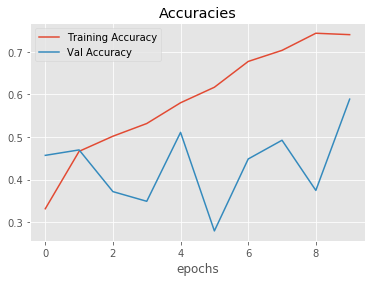

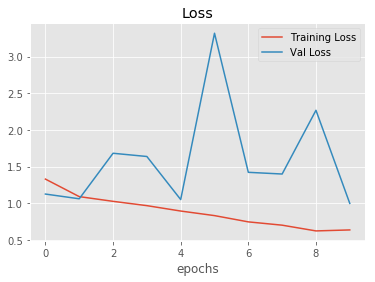

In [10]:
test_score = model.evaluate(test_data, test_labels, batch_size=32)
print "Test Score: {}".format(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')